In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

## Рубежный контроль №1: "Регуляризация в линейных моделях"

ФИО: Исмаилов Адиль \
Группа: ИУ9-72Б \
Вариант: 11 % 5 + 1 = 2

## Описание задания:
Для многомерной регрессионной задачи с мультиколлинеарностью (sklearn.datasets.make_regression — обеспечить в сформированных данных не менее 3-х сильно связаных признаков (effective_rank, tail_strength) n_features=50, n_informative=1 + <день рождения>/2, n_samples=1000, noise=0.1 * <день рождения>). 

Требуется:

1. Реализовать ridge-регрессию с L2-регуляризацией.
2. Исследовать влияние параметра регуляризации на переобучение.
3. Построить график зависимости ошибки от λ. 
4. Выбрать оптимальное значение λ с помощью кросс-валидации

#### 0. Создадим датасет согласно заданию, который имеет не менее 3-х сильно коррелированных признаков.

- effective_rank=3 - остальные 47 признаков будут линейными комбинациями 3 основных признаков, создавая мультиколлинеарность.
- tail_strength=0.1 - большая часть вариации данных сосредоточена в нескольких первых сингулярных значениях, что усиливает
  мультиколлинеарность.

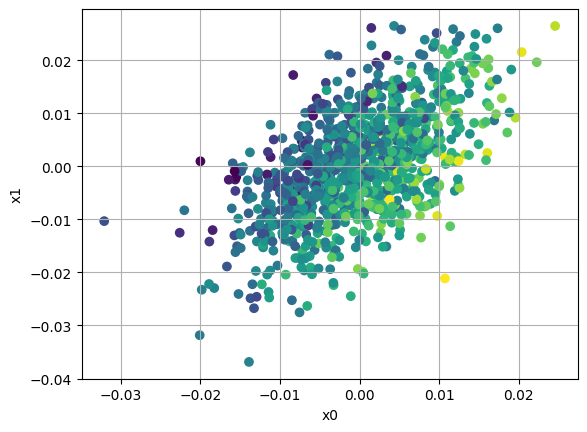

In [115]:
birthday = 16

X, y = make_regression(
    n_samples=1000,
    n_features=50,
    n_informative=1+birthday//2,  
    noise=0.1*birthday,  
    effective_rank=3, 
    tail_strength=0.1,  
    random_state=42
)

plt.scatter(X[:, 0], X[:, 1], c = y)
plt.grid()
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

Убедимся с помощью матрицы корреляций, что получилось не менее 3-х сильно коррелированных признаков.

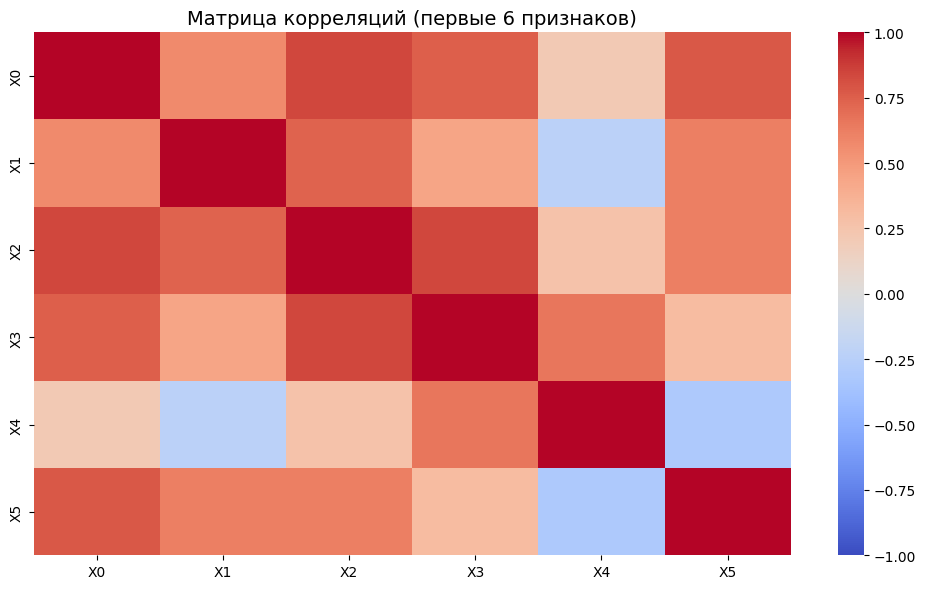

In [116]:
def analyze_correlations(X):
    df = pd.DataFrame(X, columns=[f'X{i}' for i in range(X.shape[1])])
    corr_matrix = df.corr()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix.iloc[:6, :6], annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Матрица корреляций (первые 6 признаков)", fontsize=14)
    plt.tight_layout()
    plt.show()

analyze_correlations(X)

Уже для первых 6 признаков видно, что x0, x2 и x3 имеют высокую корреляцию, примерно > 0.75

Нормализуем датасет по признакам – важный этап при использовании модели с регуляризацией, т.к. иначе можем занулить признаки с маленьким масштабом.

In [117]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"train shape: {X_train.shape} test shape: {X_test.shape}")

train shape: (800, 50) test shape: (200, 50)


#### 1. Реализуем ridge-регрессию с L2-регуляризацией.

In [118]:
class LinearRegression:
    def __init__(self, lr=0.01, n_iter=1000, alpha=0.1):
        self.lr = lr
        self.n_iter = n_iter
        self.tol = 0.00001
        self.random_state = 42
        self.npr = np.random.RandomState(self.random_state)
        self.w = None
        self.bias = self.npr.uniform(-np.sqrt(3), np.sqrt(3), size=1)[0]
        self.alpha = alpha

    def get_penalty(self):
        return self.alpha * np.sum(self.w ** 2)

    def get_loss(self, X, y):
        n = X.shape[0]
        return (X @ self.w + self.bias - y).T @ (X @ self.w + self.bias - y) / n + self.get_penalty()

    def get_loss_grad(self, X, y):
        n = X.shape[0]
        return 2 * X.T @ (X @ self.w + self.bias - y) / n

    def get_loss_grad_bias(self, X, y):
        n = X.shape[0]
        return 2 * np.sum(X @ self.w + self.bias - y) / n

    def get_penalty_grad(self):
        return self.alpha * 2 * self.w

    def fit(self, X, y):
        self.w = self.npr.uniform(-np.sqrt(6/(X.shape[1]+1)), np.sqrt(6/(X.shape[1]+1)), size=X.shape[1])

        x_train, y_train = X, np.asarray(y).ravel()

        loss = self.get_loss(x_train, y_train)
        best_loss = np.inf

        current_iter = 1
        losses = [loss]
        
        while current_iter < self.n_iter \
                and best_loss - loss >= self.tol:
            best_loss = loss

            grad_w = self.get_loss_grad(x_train, y_train) + self.get_penalty_grad()
            self.w -= self.lr * grad_w
            self.bias -= self.lr * self.get_loss_grad_bias(x_train, y_train)

            loss = self.get_loss(x_train, y_train)
            losses.append(loss)
            current_iter += 1

        return losses

    def predict(self, X):
        return X @ self.w + self.bias

    def get_params(self):
        return {'weights': self.w, 'bias': self.bias}

#### 2. Исследуем влияние параметра регуляризации на переобучение.

Обучим модель с различными значениями λ. Сохраним лоссы для train выборки. В качестве оценки
качества работы модели будем использовать MSE. Сохраним эту метрику для train и test выборок. 
Ещё сохраним gap – разрыв между test и train выборками.

In [119]:
alphas = [0, 0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 10.0]

results = {}
    
for alpha in alphas:
    model = LinearRegression(lr=0.01, n_iter=1000, alpha=alpha)
    train_losses = model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)
    
    results[alpha] = {
        'losses': train_losses,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'gap': test_mse - train_mse,
        'weight_norm': np.sum(model.w ** 2)
    }

Отобразим полученные результаты в виде таблицы

In [120]:
results_table = pd.DataFrame({
    'λ': alphas,
    'train mse': [results[k]['train_mse'] for k in results],
    'test mse': [results[k]['test_mse'] for k in results],
    'gap': [results[k]['gap'] for k in results],
    'weight_norm': [results[k]['weight_norm'] for k in results],
})

results_table

,λ,train mse,test mse,gap,weight_norm
0,0.0000,2.547620,3.339392,0.791772,2.078009
1,0.0001,2.547635,3.339140,0.791505,2.074017
2,0.0005,2.547698,3.338137,0.790439,2.058172
3,0.0010,2.547781,3.336894,0.789113,2.038630
4,0.0020,2.547957,3.334439,0.786482,2.000416
5,0.0050,2.548574,3.327324,0.778750,1.892369
6,0.0100,2.549857,3.316237,0.766380,1.732139
7,0.0200,2.553146,3.296574,0.743428,1.472596
8,0.0500,2.565793,3.252192,0.686399,1.000855
9,0.1000,2.588556,3.206206,0.617650,0.656907


### 3. Построим график зависимости ошибки от λ

Построим графики зависимости train/test ошибок, gap и нормы весов от λ.

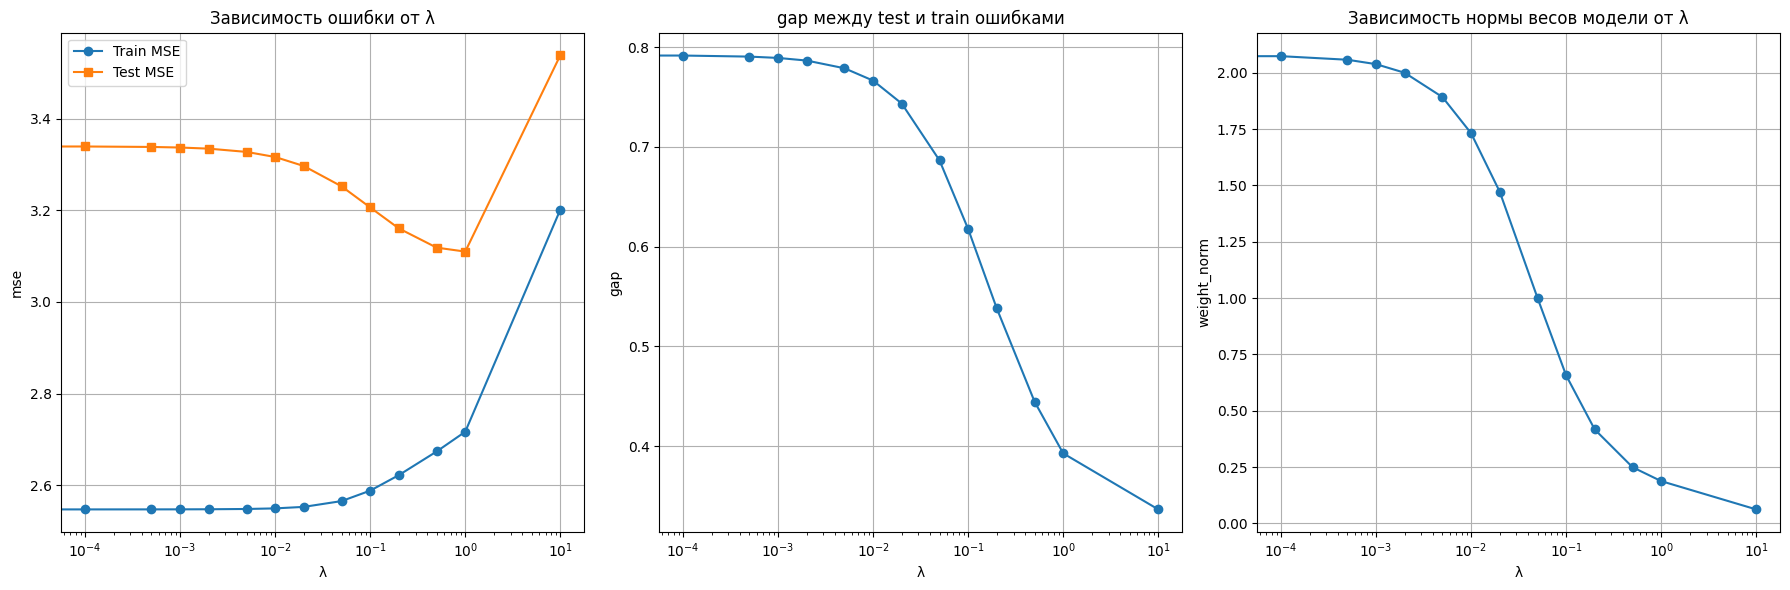

In [121]:
train_mses = [results[alpha]['train_mse'] for alpha in alphas]
test_mses = [results[alpha]['test_mse'] for alpha in alphas]    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.semilogx(alphas, train_mses, 'o-', label='Train MSE')
ax1.semilogx(alphas, test_mses, 's-', label='Test MSE')
ax1.set_xlabel('λ')
ax1.set_ylabel('mse')
ax1.set_title('Зависимость ошибки от λ')
ax1.legend()
ax1.grid(True)

gaps = [results[k]['gap'] for k in results]    
ax2.semilogx(alphas, gaps, 'o-')
ax2.set_xlabel('λ')
ax2.set_ylabel('gap')
ax2.set_title('gap между test и train ошибками')
ax2.grid(True)

weight_norms = [results[k]['weight_norm'] for k in results]    
ax3.semilogx(alphas, weight_norms, 'o-')
ax3.set_xlabel('λ')
ax3.set_ylabel('weight_norm')
ax3.set_title('Зависимость нормы весов модели от λ')
ax3.grid(True)

plt.tight_layout()
plt.show()

#### Вывод по влиянию λ на переобучение

1. С ростом λ от 0 до 1 train ошибка увеличивается с 2.548 до 2.717, что говорит о том, что модель хуже подстраивается под
   train данные, т.е. с увеличением λ модель меньше переобучается.
2. С ростом λ от 0 до 1 test ошибка уменьшается с 3.339 до 3.110, что говорит об увеличении обобщающей способности модели,
   т.е. с увеличением λ модель меньше переобучается и лучше предсказывает test выборку.
3. С ростом λ Gap уменьшается, что следует из 1 и 2 пункта: ошибка для test уменьшается, а для train увеличивается. Это свидетельствует об отсутствии переобучения.
4. С ростом λ норма весов уменьшается, что говорит об упрощении модели и об отсутствии переобучения.
5. При λ = 10 происходит обратный эффект: ошибки на train и test резко увеличиваются, норма весов модели резко уменьшается. Это говорит
   о недообучении модели, т.е. из-за того, что модель стала сильно штрафовать веса, она стала слишком простой и плохо обучилась.

### 4. Выберем оптимальное значение λ с помощью кросс-валидации

Как было видно из предыдущего пункта, при слишком маленьких λ модель больше переобучается, а при слишком больших λ модель недообучается.
Выберем λ так, чтобы среднеарифметическое по всем λ ошибок на валидации было минимальным. Такой подход ищет модель с наилучшей обобщающей способностью, которая смогла обучиться и в то же время не переобучилась.

In [122]:
def cross_validation(X, y, alphas, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results = {alpha: [] for alpha in alphas}
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        for alpha in alphas:
            model = LinearRegression(lr=0.01, n_iter=1000, alpha=alpha)
            model.fit(X_train, y_train)
            
            y_val_pred = model.predict(X_val)
            val_mse = np.mean((y_val - y_val_pred) ** 2)
            
            results[alpha].append(val_mse)
    
    mean_val_mses = {alpha: np.mean(val_mses) for alpha, val_mses in results.items()}
    optimal_alpha = min(mean_val_mses, key=mean_val_mses.get)
    
    return optimal_alpha, mean_val_mses

In [123]:
optimal_alpha, mean_val_mses = cross_validation(X_scaled, y, alphas)
print(f"best λ = {optimal_alpha} best mean val mse = {mean_val_mses[optimal_alpha]}")

best λ = 0.5 best mean val mse = 2.843753951823721


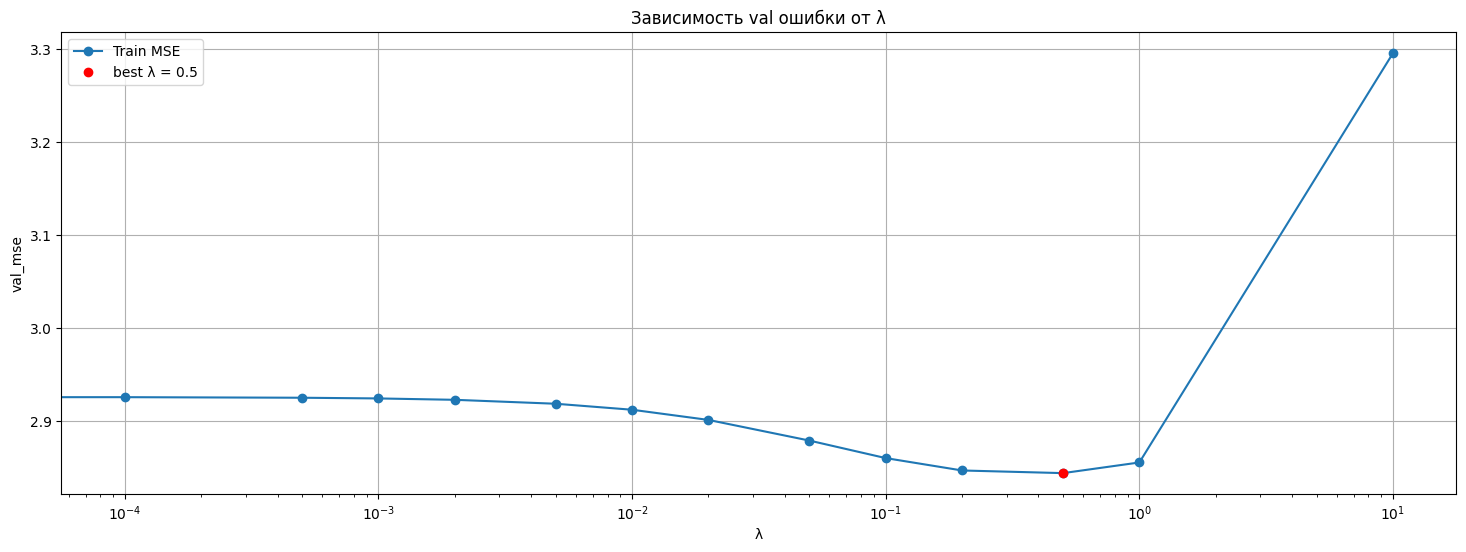

In [124]:
val_mses = [mean_val_mses[alpha] for alpha in alphas]  
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 6))

ax1.semilogx(alphas, val_mses, 'o-', label='Train MSE')
optimal_index = alphas.index(optimal_alpha)
ax1.plot(optimal_alpha, val_mses[optimal_index], 'ro', markersize=6, label=f'best λ = {optimal_alpha}')

ax1.set_xlabel('λ')
ax1.set_ylabel('val_mse')
ax1.set_title('Зависимость val ошибки от λ')
ax1.legend()
ax1.grid(True)

#### Вывод по работе

Реализовал линейную регрессию с регуляризацией L2. Исследовал, как влияет параметр регуляризации на переобучение. Был сделан вывод, что с увеличением λ модель меньше переобучается и больше увеличивает обобщающую способность, однако для слишком больших λ модель уже недообучается. С помощью кросс-валидации был получен оптимальный λ = 0.5, для которого модель имеет наилучшую обобщающую способность, т.е. модель не имеет проблем недообучения и переобучения.